### 프로젝트 개요

- 본 프로젝트는 베이커리 구매 데이터를 기반으로 장바구니 분석을 활용하여 
- 고객의 구매 패턴 및 상품 간의 상호작용을 파악하고 베이커리의 매출 증대 및 고객 만족도를 높이는 방법을 찾는다.

- 2016년 10월 30일~2017년 4월 9일까지의 Kaggle 에든버러에 위치한 제과점 "The Bread Basket"의 데이터 활용

| 컬럼명             | 설명                       |  
|-----------------|--------------------------|
| Transaction     | 거래ID                     |   
| Item            | 구매한 제품명                  |  
| date_time       | 거래 날짜 및 시각               |   
| period_day      | 아침/오후/저녁/밤 중 언제 구매했는지 여부 |   
| weekday_weekend | 주중/주말 중 언제 구매했는지 여부      |   


### 장바구니 분석 기반 마케팅 전략 제안
- 크로스셀링을 통한 매출 증대 유도 
    - 향상도(Lift)⬆️ 신뢰도(Conf)⬇️: 선택형 크로스셀링 및 감성 진열 전략으로 접근 
    - 신뢰도가 높은 조합은 실질적 구매 패턴을 반영하므로 세트 상품 구성 및 전면 진열 배치에 적합

| 연관 규칙            | Conf/Lift    | EDA 인사이트                                                    | 마케팅 전략 제안 |
|------------------|--------------|-------------------------------------------------------------|-----------|
| Toast -> Coffee  | 70.4%/1.47   | - Toast: 인기 상품은 아님, 아침 시간대 소비 <br>- Coffee: 스테디셀러 상품 | - 모닝 세트 구성 -> 세트 구매 시 할인<br> - 아침 시간대 추천 상품존 진열 |
| Cake -> Tea      | 22.9%/1.60   | 	- Cake: 주말 오후에 집중<br>- Tea: 전체 판매는 낮지만 특정 조합에서 의미 있음       |- 신뢰도는 낮아 전면 배치 부담될 수 있음 <br>- "케이크와 잘어울리는 차" 테마 진열대 구성 <br> - 케이크 옆 추천 차 종류 표시|
| Pastry -> Coffee | 55.2% / 1.15 | - Pastry: 오전/주말에 잘 팔림<br>- Coffee: 모든 요일, 시간대 인기 | - 브런치 세트 구성 <br> - 메뉴판 내 페이스트리+커피 추천 문구 표시  |



### 환경 설정 및 데이터 불러오기

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import koreanize_matplotlib

In [4]:
data_path = '/Users/SongKG/Downloads/bakery_sales_revised.csv'

bakery_df2 = pd.read_csv(data_path)

bakery_df = bakery_df2.copy()
bakery_df.tail(2)

,Transaction,Item,date_time,period_day,weekday_weekend
20505,9683,Pastry,4/9/2017 14:57,afternoon,weekend
20506,9684,Smoothies,4/9/2017 15:04,afternoon,weekend


In [5]:
bakery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


### 1. EDA

#### 1-1 결측값 및 중복값 확인 
- 중복값 1620개 존재 
- 데이터에 수량을 나타내는 컬럼이 없으므로, 동일 트랜잭션 내 중복 데이터들은 같은 물품을 여러 개 구매한 것으로 판단하여 삭제X

In [10]:
bakery_df.isnull().sum()

Transaction        0
Item               0
date_time          0
period_day         0
weekday_weekend    0
dtype: int64

In [16]:
bakery_df.duplicated().sum()

1620

In [40]:
# 그룹별 개수 확인
bakery_df.groupby(['Transaction', 'Item', 'date_time', 'period_day', 'weekday_weekend']).size().reset_index(name='Quantity').query('Quantity > 1').sort_values(by='Quantity',ascending=False)

,Transaction,Item,date_time,period_day,weekday_weekend,Quantity
13170,6887,Coffee,2/19/2017 15:41,afternoon,weekend,4
12457,6560,Coffee,2/14/2017 12:36,afternoon,weekday,4
13072,6850,Coffee,2/19/2017 11:46,morning,weekend,4
10179,5455,Coffee,1/27/2017 16:38,afternoon,weekday,3
16097,8328,Bread,3/18/2017 8:58,morning,weekend,3
...,...,...,...,...,...,...
7451,4008,Bread,12/30/2016 13:28,afternoon,weekday,2
7442,4002,Hot chocolate,12/30/2016 12:32,afternoon,weekday,2
7419,3992,Bread,12/30/2016 11:33,morning,weekday,2
7403,3984,Bread,12/30/2016 10:14,morning,weekday,2


In [ ]:
# 통계량 확인
bakery_df.describe(include='object')

,Item,date_time,period_day,weekday_weekend
count,20507,20507,20507,20507
unique,94,9182,4,2
top,Coffee,2/5/2017 11:58,afternoon,weekday
freq,5471,12,11569,12807


- 총 9465건의 거래 발생
- 에든버러 제과점에서는 94개의 물품 판매중

In [47]:
bakery_df['Transaction'].nunique()

9465

In [54]:
bakery_df['Item'].nunique()

94

#### 1-2 시간대별 구매량 분석

In [41]:
# 날짜 데이터 타입 변경
bakery_df['date_time'] = pd.to_datetime(bakery_df['date_time'])

In [42]:
bakery_df.tail(2)

,Transaction,Item,date_time,period_day,weekday_weekend
20505,9683,Pastry,2017-04-09 14:57:00,afternoon,weekend
20506,9684,Smoothies,2017-04-09 15:04:00,afternoon,weekend


In [56]:
# 시간대별 분석 위한 파생 변수 생성
bakery_df['weekday_name'] = bakery_df['date_time'].dt.day_name() # 요일 
bakery_df['hour'] = bakery_df['date_time'].dt.hour

- 여름, 가을 데이터 존재 X 
- 계절성 확인 어려움

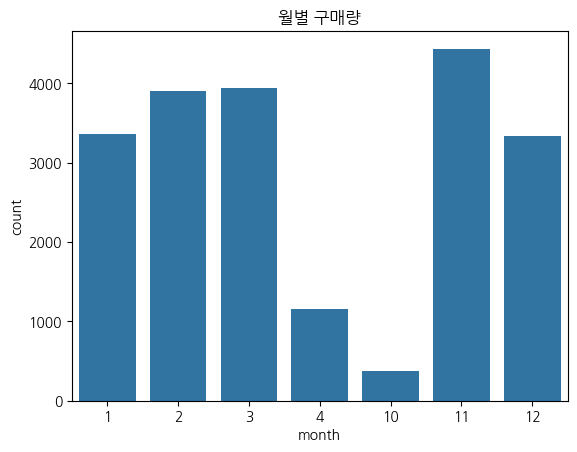

In [101]:
sns.countplot(data=bakery_df, x='month')
plt.title('월별 구매량')
plt.show()

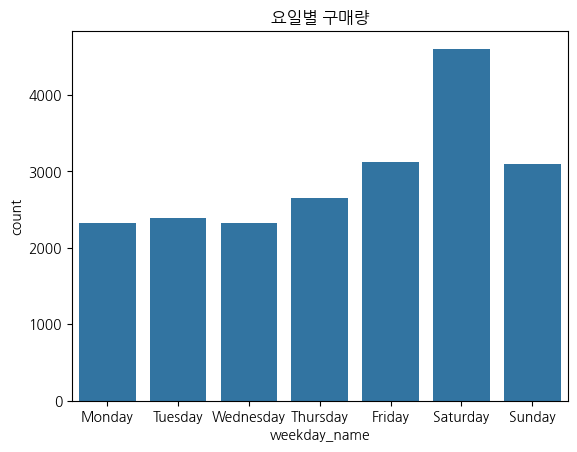

In [53]:
sns.countplot(data=bakery_df, x='weekday_name', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('요일별 구매량')
plt.show()

In [172]:
daily_sales = bakery_df.groupby(['weekday_weekend', 'weekday_name']).size().reset_index(name='purchase_count')
daily_sales

,weekday_weekend,weekday_name,purchase_count
0,weekday,Friday,3124
1,weekday,Monday,2324
2,weekday,Thursday,2646
3,weekday,Tuesday,2392
4,weekday,Wednesday,2321
5,weekend,Saturday,4605
6,weekend,Sunday,3095


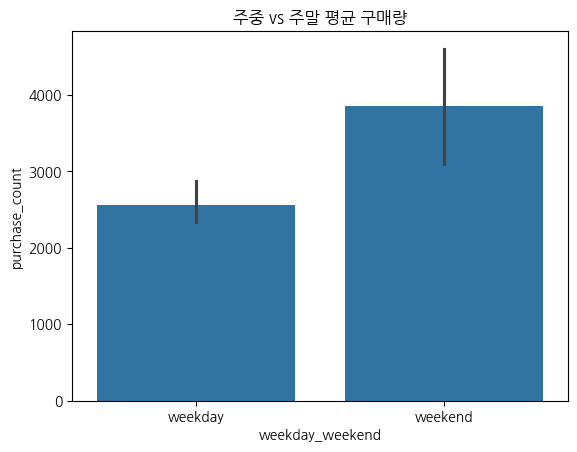

In [174]:
sns.barplot(data=daily_sales, x='weekday_weekend', y='purchase_count', estimator='mean')
plt.title('주중 vs 주말 평균 구매량')
plt.show()


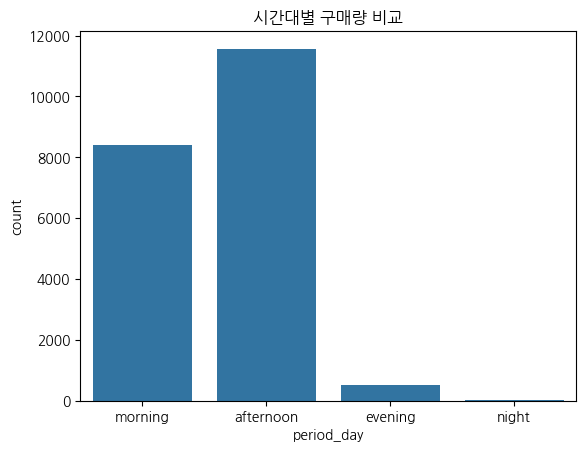

In [48]:
sns.countplot(data=bakery_df, x='period_day')
plt.title('시간대별 구매량 비교')
plt.show()

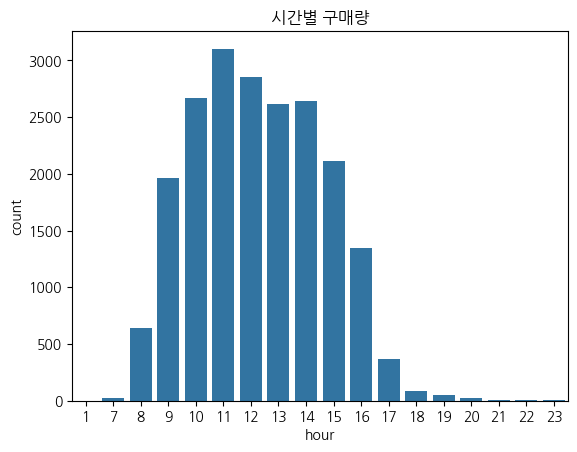

In [58]:
sns.countplot(data=bakery_df, x='hour')
plt.title('시간별 구매량')
plt.show()

#### 1-3 제품별 구매량 분석

- 전체 상품중 상위 10개 상품의 거래량이 73%를 차지함(파레토 법칙)
    - 인기 상품 판매에 집중해야함을 시사함

In [142]:
# Top10 상품이 전체 거래량 중 몇%를 차지하는지 
total_count = bakery_df.shape[0]

top10_items = bakery_df['Item'].value_counts().head(10)
# 3. Top 10 거래량 합계
top10_count = top10_items.sum()

# 4. 비율 계산 (%)
top10_ratio = top10_count / total_count * 100

# 5. 결과 출력
print(f"Top 10 상품은 전체 거래의 약 {top10_ratio:.2f}%를 차지합니다.")

Top 10 상품은 전체 거래의 약 73.18%를 차지합니다.


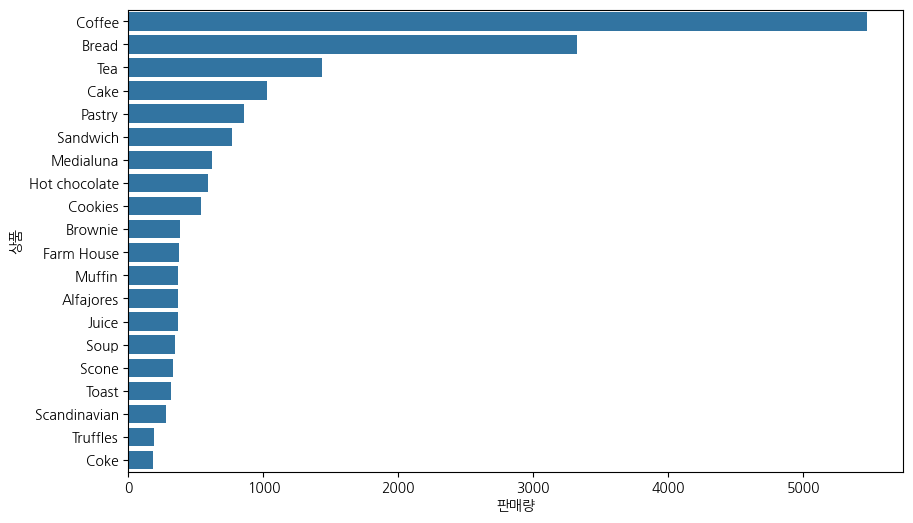

In [61]:
# 인기 상품 TOP 20 
top_items = bakery_df['Item'].value_counts().head(20)
plt.figure(figsize=(10,6))
sns.barplot(x=top_items.values, y=top_items.index)
plt.xlabel('판매량')
plt.ylabel('상품')
plt.show()

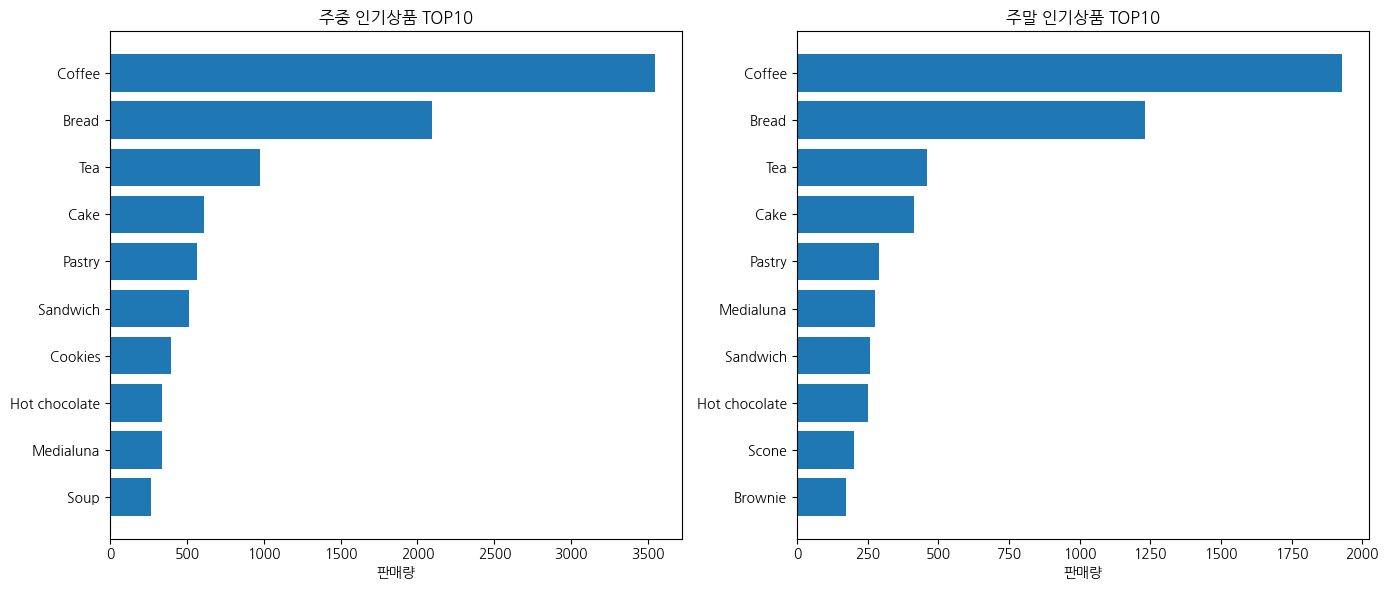

In [ ]:
# 주중/주말 인기상품 TOP10 판매량 비교
weekday_df = bakery_df[bakery_df['weekday_weekend'] == 'weekday']
weekend_df = bakery_df[bakery_df['weekday_weekend'] == 'weekend']

# TOP10 인기상품 추출
top10_weekday = weekday_df['Item'].value_counts().head(10)
top10_weekend = weekend_df['Item'].value_counts().head(10)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.barh(top10_weekday.index[::-1], top10_weekday.values[::-1])
plt.title('주중 인기상품 TOP10')
plt.xlabel('판매량')

plt.subplot(1,2,2)
plt.barh(top10_weekend.index[::-1], top10_weekend.values[::-1])
plt.title('주말 인기상품 TOP10')
plt.xlabel('판매량')

plt.tight_layout()
plt.show()

- Bread, Pastry, Mediaruna 빵류가 아침에 잘팔림

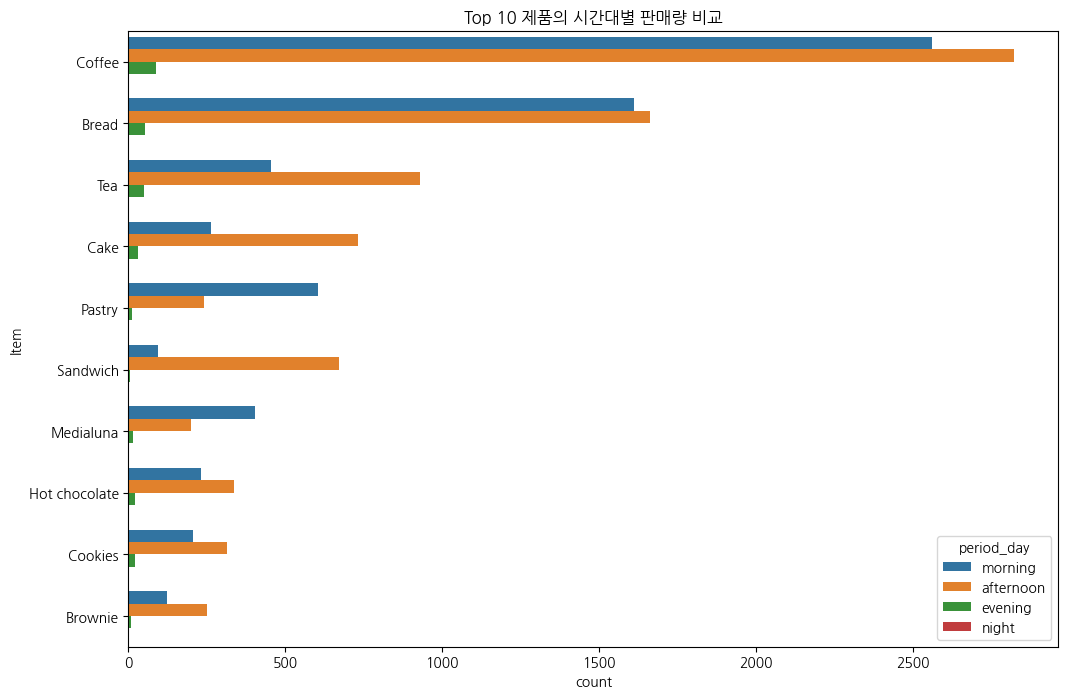

In [66]:
# 제품별 시간대별 판매량
plt.figure(figsize=(12,8))
sns.countplot(data=top10_df, y='Item', hue='period_day', order=top10_items)
plt.title('Top 10 제품의 시간대별 판매량 비교')
plt.show()

<Axes: xlabel='weekday_name', ylabel='count'>

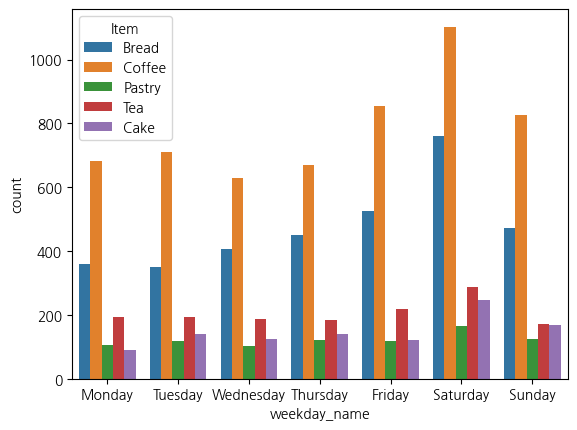

In [85]:
# TOP5 상품의 요일별 구매량 비교
# 인기 상품 TOP 5
top5_items = bakery_df['Item'].value_counts().head(5).reset_index()
top5_df = bakery_df[bakery_df['Item'].isin(top5_items['Item'])]

sns.countplot(data=top5_df, x='weekday_name', hue='Item', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

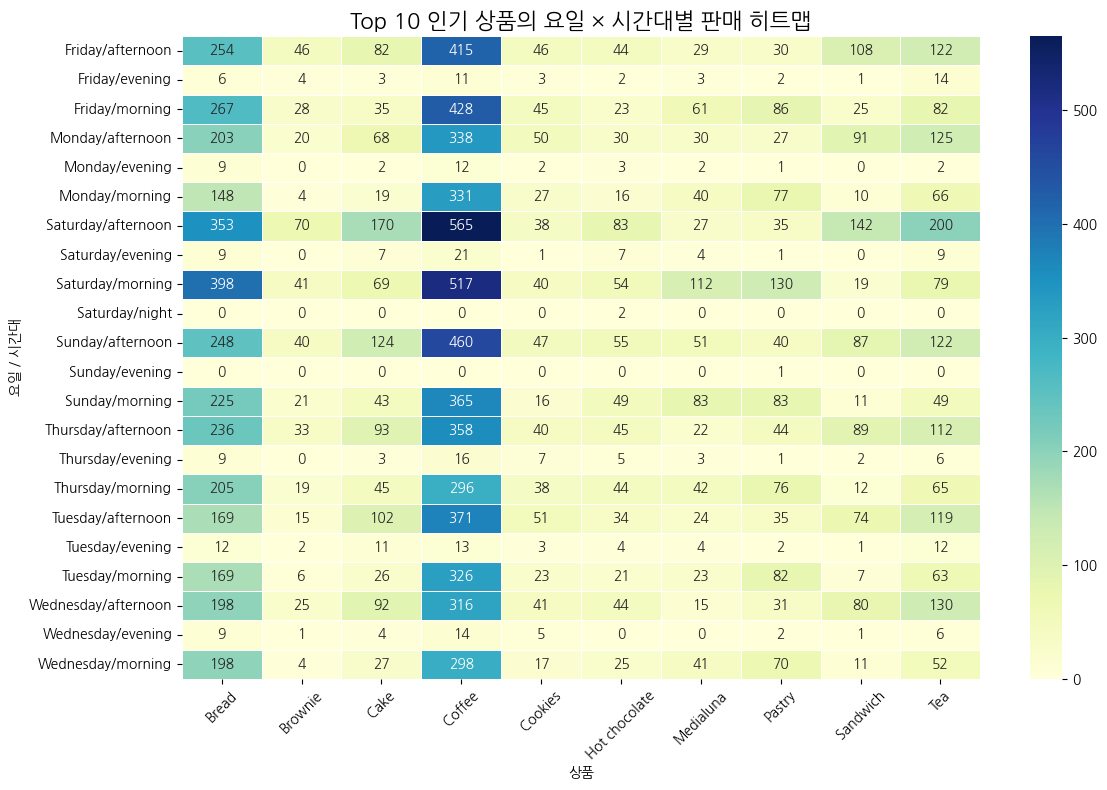

In [143]:
# 요일 + 시간대 컬럼 생성 
bakery_df['period_weekday'] = bakery_df['weekday_name'] + '/' + bakery_df['period_day']
# 2. 전체에서 인기 상품 Top 10 추출
top_items = bakery_df['Item'].value_counts().head(10).index.tolist()

# 3. Top10만 필터링
top_df = bakery_df[bakery_df['Item'].isin(top_items)]

# 4. 그룹핑: 요일/시간대 × Item 별 count
grouped = top_df.groupby(['period_weekday', 'Item']).size().reset_index(name='count')

# 5. 피벗 테이블로 변환
pivot_df = grouped.pivot(index='period_weekday', columns='Item', values='count').fillna(0)

# 6. 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.5, annot=True, fmt='.0f')
plt.title("Top 10 인기 상품의 요일 × 시간대별 판매 히트맵", fontsize=16)
plt.xlabel("상품")
plt.ylabel("요일 / 시간대")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### 1-4 EDA 인사이트 정리

|            | 분석 결과                                        |  
|------------|----------------------------------------------|
| 요일별 구매 경향  | 구매는 주말 오전~오후에 집중되며, 특히 토요일이 가장 활발            |   
| 시간대별 구매 경향 | 아침~런치타임이 핵심 시간대이고, 저녁은 상대적으로 저조              |   
| 상품별 판매 특징  | 커피는 전 시간대 고른 강세를 보이며, 빵류는 아침·디저트류는 오후에 집중    |  
| 인기 상품 구성   | 상위 10개 인기 상품이 전체 매출의 70% 이상을 차지하며, 상품 편중이 뚜렷 |  

### 2. 장바구니 분석

-본 장바구니 분석은 고객의 연관 구매 패턴을 파악하여 세트 상품 개발 및 마케팅 전략 수립 등 실질적인 비즈니스 의사결정에 활용하기 위해 위한 목적을 가지고 수행되었습니다.

```python
- 연관 규칙 평가 지표
    - 지지도(Support): 얼마나 자주 등장하는가?
    - 신뢰도(Confidence): A를 샀을 때 B도 함께 사는가?
    - 향상도(Lift): A와 B가 실제로 연관되었는가?
```

#### 2-1 Transaction별 Item 리스트 만들기

In [ ]:
basket_df = bakery_df.groupby('Transaction')['Item'].apply(list).reset_index()
basket_df[:5]

,Transaction,Item
0,1,[Bread]
1,2,"[Scandinavian, Scandinavian]"
2,3,"[Hot chocolate, Jam, Cookies]"
3,4,[Muffin]
4,5,"[Coffee, Pastry, Bread]"


In [118]:
#!pip install mlxtend

#### 2-2 장바구니 원핫 인코딩 처리

In [122]:
# 원핫 인코딩 처리
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit_transform(basket_df['Item'])
te_ary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [124]:
te_df = pd.DataFrame(te_ary, columns=te.columns_)
te_df.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [125]:
te_df.shape

(9465, 94)

#### 2-3 Apriori 알고리즘
- 최소 지지도를 기준으로 빈발 항목 집합(Frequent Itemset)을 탐색하고, 이로부터 연관 규칙을 도출하는 알고리즘
- 도출된 규칙은 지지도(Support), 신뢰도(Confidence), 향상도(Lift)를 기준으로 빈도, 신뢰성, 연관성을 종합적으로 평가합니다.

- 의미 있는 연관 규칙 도출하기 위해 빈도가 낮은 조합은 제외합니다.
    - 최소 지지도(0.02) => 약 1000건의 거래가 있다면 20건 이상 등장한 조합만 자주 등장한 조합으로 선정합니다.

In [ ]:
from mlxtend.frequent_patterns import apriori 

# 최소 support 2% 기준 Frequent Itemsets 추출 
frequent_items = apriori(te_df,min_support=0.02, use_colnames=True)
frequent_items.shape

(33, 2)

In [205]:
frequent_items.sort_values(by='support', ascending=False).head(15)

,support,itemsets
4,0.478394,(Coffee)
1,0.327205,(Bread)
16,0.142631,(Tea)
3,0.103856,(Cake)
20,0.090016,"(Bread, Coffee)"
11,0.086107,(Pastry)
12,0.071844,(Sandwich)
9,0.061807,(Medialuna)
7,0.058320,(Hot chocolate)
23,0.054728,"(Cake, Coffee)"


#### 2-4 Association Rules 생성

In [206]:
from mlxtend.frequent_patterns import association_rules
use_cols = [
    'antecedents',
    'consequents',
    'support',
    'confidence',
    'lift'
]

In [207]:
fp_rules = association_rules(
    frequent_items, 
    metric='confidence',
    min_threshold=0.2
)[use_cols]
fp_rules.sort_values(by='lift', ascending=False).head(6)

,antecedents,consequents,support,confidence,lift
4,(Cake),(Tea),0.023772,0.228891,1.604781
12,(Toast),(Coffee),0.023666,0.704403,1.472431
8,(Medialuna),(Coffee),0.035182,0.569231,1.189878
9,(Pastry),(Coffee),0.047544,0.552147,1.154168
7,(Juice),(Coffee),0.020602,0.534247,1.116750
10,(Sandwich),(Coffee),0.038246,0.532353,1.112792


#### 2-5 장바구니 분석 결과 주요 해석
| 조건 상품(Antecedent) | 함께 구매된 상품(Consequent) | Confidence(%) | Lift | 연관성 해석                          |  
|-------------------|-----------------------|---------------|------|---------------------------------|
| Toast             | Coffee                | 70.4%         | 1.47 | 연관도는 높지만 토스트의 구매 비중은 낮음 -> 토스트 구매 유도 및 세트 판매 기회|  
| Cake              | Tea                   | 22.9%         | 1.60 | 자주 함께 팔리진 않지만 연관도는 높음 -> 케이크 구매 고객 대상 티 할인 이벤트 가능 |   
| Medialuna(빵류)        | Coffee                | 56.9%         | 1.19 | 약한 연관성 - 브런치 세트 가능              |  
| Pastry(빵류)            | Coffee                | 55.2%         | 1.15 | 약한 연관성 - 기본 추천 조합               |   
| Sandwich(빵류)          | Coffee                | 53.2%         | 1.11 | 약한 연관성 - 모닝 세트 추천          |  